<a href="https://colab.research.google.com/github/yeonghun00/stock-notes/blob/main/analysis/low_traded_incrased_stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

기간 입력

거래대금 하위 10%~50%

등락률 상위 50%~10%

클라스로 만들어서 백테스팅 가능하게 ㄱ

In [1]:
!pip install exchange_calendars

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 189 kB 5.1 MB/s 


In [2]:
!pip install finance-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


250일 등락률, 거래대금 90-99: 범인매매

60일 등락률 50-100, 거래대금 10-50 : 조용히 오르는 애들 (내꺼)



In [3]:
period = 60

increased_low = 0.5
increased_high = 1

traded_low = 0.1
traded_high = 0.5

In [4]:
import pandas as pd
import requests
import datetime
import exchange_calendars as ecals # 개장일만

In [5]:
XKRX = ecals.get_calendar("XKRX") # 한국 코드

In [6]:
today = datetime.date.today().strftime('%Y%m%d')

In [7]:
start = (datetime.date.today() - datetime.timedelta(days=period)).strftime('%Y%m%d')

if XKRX.is_session(today) == False:
  today = XKRX.previous_open(today).strftime('%Y%m%d')
if XKRX.is_session(start) == False:
  start = XKRX.next_open(start).strftime('%Y%m%d')

In [8]:
from io import StringIO

def get_stocks(market='STK'):
  data = {
    'mktId': market,
    'strtDd': start,
    'endDd': today,
    'money': '1',
    'adjStkPrc': '2',
    'adjStkPrc_check': 'Y',
    'share': '1',
    'csvxls_isNo': 'false',
    'name': 'fileDown',
    'url': 'dbms/MDC/STAT/standard/MDCSTAT01602'
  }
  gen_url = 'http://data.krx.co.kr/comm/fileDn/GenerateOTP/generate.cmd'
  gen_key = requests.post(gen_url, data=data)

  down_url = 'http://data.krx.co.kr/comm/fileDn/download_csv/download.cmd'
  r = requests.post(down_url, data={'code':gen_key.text})
  r.encoding = 'EUC-KR'

  return pd.read_csv(StringIO(r.text))

In [9]:
df = pd.concat([get_stocks(), get_stocks('KSQ')]).reset_index(drop=True)

In [10]:
df

,종목코드,종목명,시작일 기준가,종료일 종가,대비,등락률,거래량,거래대금
0,095570,AJ네트웍스,6930,5820,-1110,-16.02,5774311,35656715400
1,006840,AK홀딩스,12400,17100,4700,37.90,931829,13222731650
2,027410,BGF,3170,4075,905,28.55,41877146,166826638220
3,282330,BGF리테일,173500,212500,39000,22.48,1996285,385110786951
4,138930,BNK금융지주,6320,7280,960,15.19,51376876,350646060980
...,...,...,...,...,...,...,...,...
2517,024060,흥구석유,5840,6110,270,4.62,15194894,95421299790
2518,010240,흥국,4990,6290,1300,26.05,2959074,17626256160
2519,189980,흥국에프엔비,2200,2895,695,31.59,20893197,54924731140
2520,037440,희림,9210,9360,150,1.63,136458711,1591983005390


In [11]:
traded_df = df[(df['거래대금'] < df['거래대금'].quantile(traded_high)) & (df['거래대금'] > df['거래대금'].quantile(traded_low))]

In [12]:
increased_df = df[(df['등락률'] > df['등락률'].quantile(increased_low)) & (df['등락률'] < df['등락률'].quantile(increased_high))]

In [13]:
import numpy as np

selected = pd.Series(np.intersect1d(traded_df['종목명'].values, increased_df['종목명'].values))

In [14]:
result_df = df[df['종목명'].isin(selected)].sort_values('등락률', ascending=False).head(20)

In [15]:
import FinanceDataReader as fdr

price_dic = {}
for i in result_df['종목코드']:
  price_dic[i] = fdr.DataReader(str(i),start,today)

In [16]:
def get_sharpe(df):
  change = df['Change']+1
  return change.mean()/change.std()

def get_sortino(df):
  change = df['Change']+1
  return change.mean()/(change[change<1]).std()

In [17]:
result_df['샤프'] = [get_sharpe(price_dic[x]) for x in price_dic]
result_df['소티노'] = [get_sortino(price_dic[x]) for x in price_dic]

In [18]:
result_df.sort_values('샤프', ascending=False)

,종목코드,종목명,시작일 기준가,종료일 종가,대비,등락률,거래량,거래대금,샤프,소티노
2452,054040,한국컴퓨터,3370,4680,1310,38.87,2880484,12050077005,60.650051,92.583783
849,014130,한익스프레스,4245,5810,1565,36.87,2465978,13217253585,55.372796,70.258981
1340,101330,모베이스,2500,3360,860,34.40,4327275,13395567285,53.087827,90.651067
465,041650,상신브레이크,2585,3535,950,36.75,1714570,5428250030,52.468470,134.314891
1382,046310,백금T&A,2270,3440,1170,51.54,4338992,12659486420,46.030491,62.796772
1351,279600,미디어젠,10800,14800,4000,37.04,782905,10069207350,44.998106,118.782426
32,155660,DSR,4490,6140,1650,36.75,5750183,34397587455,38.739780,123.122662
2453,021650,한국큐빅,2310,3210,900,38.96,2011801,5715879360,37.452162,54.373075
1508,053060,세동,1060,1525,465,43.87,7597934,10351740250,36.763521,57.396342
1,006840,AK홀딩스,12400,17100,4700,37.90,931829,13222731650,35.787066,60.432822


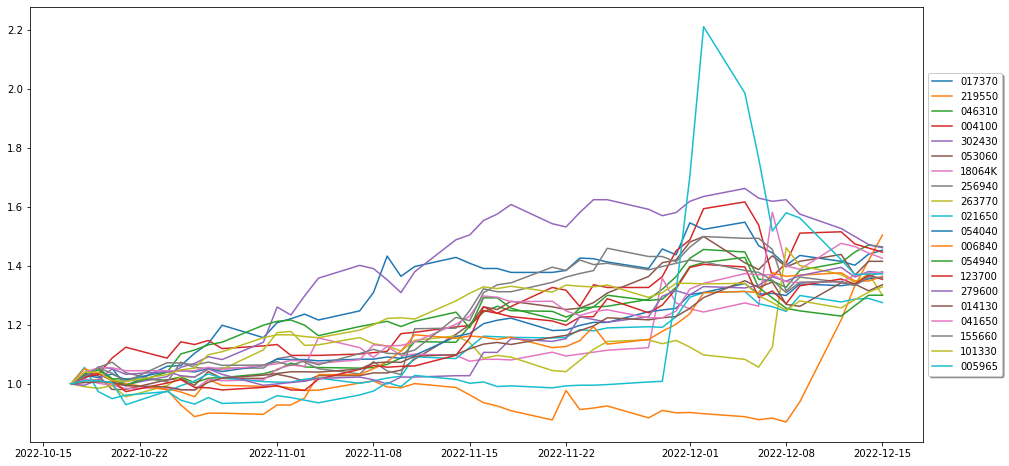

In [19]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 8))
ax = plt.subplot(111)

for i in price_dic:
  ax.plot(price_dic[i]['Close']/price_dic[i]['Close'][0], label=i)
ax.legend(loc='center left',  bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)

plt.show()